In [184]:
from copy import deepcopy as copy

import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import os
import datetime as dt
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline 

In [185]:
def load_data(company, start, end):
    data = web.DataReader(company, 'yahoo', start, end)
    return data

In [186]:
company = 'PFE'

In [187]:
data = load_data(company = company,
                 start = dt.datetime(1972,1,1),
                 end = dt.datetime(2020,1,1))
display(data)
data=data.dropna()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1972-06-01,0.815346,0.802993,0.000000,0.815346,2458771.0,0.187400
1972-06-02,0.817817,0.802993,0.815346,0.805463,1613885.0,0.185129
1972-06-05,0.807934,0.798051,0.805463,0.802993,2585251.0,0.184561
1972-06-06,0.825229,0.800522,0.802993,0.820288,2347469.0,0.188536
1972-06-07,0.820288,0.807934,0.820288,0.820288,1032077.0,0.188536
...,...,...,...,...,...,...
2019-12-24,37.419353,37.191650,37.314991,37.277039,5187683.0,35.428619
2019-12-26,37.542694,37.191650,37.286530,37.362431,9384078.0,35.509777
2019-12-27,37.590134,37.239090,37.409866,37.305504,10117662.0,35.455673


In [188]:
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Close'])
for i in range(0,len(data)):
    new_data['Close'][i] = data['Close'][i]
display(new_data)

,Close
0,0.815346
1,0.805463
2,0.802993
3,0.820288
4,0.820288
...,...
11996,37.277039
11997,37.362431
11998,37.305504
11999,36.916508


In [189]:
scaler = MinMaxScaler(feature_range=(0,1))

In [190]:
df_sc = scaler.fit_transform(new_data.values.reshape(-1,1))
display(df_sc)
df_sc.shape

array([[0.0082445 ],
       [0.00803444],
       [0.00798195],
       ...,
       [0.78379877],
       [0.77553113],
       [0.78097568]])

(12001, 1)

In [191]:
train_end=int(len(df_sc)*.6)
val_end = train_end+int(len(df_sc)*.2)


In [192]:
un_train_df= new_data[:train_end].values.reshape(-1,1)
# un_train_df.shape
train_df = df_sc[:train_end]
# train_df.shape
un_train_df.shape

(7200, 1)

In [193]:
un_val_df= new_data[train_end:val_end].values.reshape(-1,1)
val_df = df_sc[train_end:val_end]
val_df.shape

(2400, 1)

In [194]:
un_test_df= new_data[val_end:].values.reshape(-1,1)
test_df = df_sc[val_end:]
un_test_df.shape

(2401, 1)

In [297]:
window = 10

In [298]:
def prepData(scaled_data, unscaled, window):
    x_train = []
    y_train = []

    for x in range(window, len(scaled_data)):
        print(x)
        print(scaled_data[x - window:x,0])
        x_train.append(scaled_data[x - window:x,0])
        y_train.append(unscaled[x,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    print(x_train.shape)
    print(y_train.shape)
    return x_train, y_train

In [299]:

x_train, y_train = prepData(train_df, un_train_df, window)
# display(x_train)

10
[0.0082445  0.00803444 0.00798195 0.00834953 0.00834953 0.0082445
 0.00834953 0.00840205 0.00855958 0.00855958]
11
[0.00803444 0.00798195 0.00834953 0.00834953 0.0082445  0.00834953
 0.00840205 0.00855958 0.00855958 0.00834953]
12
[0.00798195 0.00834953 0.00834953 0.0082445  0.00834953 0.00840205
 0.00855958 0.00855958 0.00834953 0.0086646 ]
13
[0.00834953 0.00834953 0.0082445  0.00834953 0.00840205 0.00855958
 0.00855958 0.00834953 0.0086646  0.00887465]
14
[0.00834953 0.0082445  0.00834953 0.00840205 0.00855958 0.00855958
 0.00834953 0.0086646  0.00887465 0.00897969]
15
[0.0082445  0.00834953 0.00840205 0.00855958 0.00855958 0.00834953
 0.0086646  0.00887465 0.00897969 0.00876963]
16
[0.00834953 0.00840205 0.00855958 0.00855958 0.00834953 0.0086646
 0.00887465 0.00897969 0.00876963 0.00882215]
17
[0.00840205 0.00855958 0.00855958 0.00834953 0.0086646  0.00887465
 0.00897969 0.00876963 0.00882215 0.00876963]
18
[0.00855958 0.00855958 0.00834953 0.0086646  0.00887465 0.00897969
 0.0

 0.00624902 0.00624902 0.00624902 0.00624902]
471
[0.00645907 0.00666912 0.00645907 0.00645907 0.00624902 0.00624902
 0.00624902 0.00624902 0.00624902 0.00666912]
472
[0.00666912 0.00645907 0.00645907 0.00624902 0.00624902 0.00624902
 0.00624902 0.00624902 0.00666912 0.00724676]
473
[0.00645907 0.00645907 0.00624902 0.00624902 0.00624902 0.00624902
 0.00624902 0.00666912 0.00724676 0.00724676]
474
[0.00645907 0.00624902 0.00624902 0.00624902 0.00624902 0.00624902
 0.00666912 0.00724676 0.00724676 0.00666912]
475
[0.00624902 0.00624902 0.00624902 0.00624902 0.00624902 0.00666912
 0.00724676 0.00724676 0.00666912 0.00666912]
476
[0.00624902 0.00624902 0.00624902 0.00624902 0.00666912 0.00724676
 0.00724676 0.00666912 0.00666912 0.00624902]
477
[0.00624902 0.00624902 0.00624902 0.00666912 0.00724676 0.00724676
 0.00666912 0.00666912 0.00624902 0.00624902]
478
[0.00624902 0.00624902 0.00666912 0.00724676 0.00724676 0.00666912
 0.00666912 0.00624902 0.00624902 0.00582892]
479
[0.00624902 0.

 0.00220553 0.00199548 0.00220553 0.00220553]
954
[0.00220553 0.00241558 0.00241558 0.00199548 0.00220553 0.00220553
 0.00199548 0.00220553 0.00220553 0.00220553]
955
[0.00241558 0.00241558 0.00199548 0.00220553 0.00220553 0.00199548
 0.00220553 0.00220553 0.00220553 0.00220553]
956
[0.00241558 0.00199548 0.00220553 0.00220553 0.00199548 0.00220553
 0.00220553 0.00220553 0.00220553 0.00241558]
957
[0.00199548 0.00220553 0.00220553 0.00199548 0.00220553 0.00220553
 0.00220553 0.00220553 0.00241558 0.00262563]
958
[0.00220553 0.00220553 0.00199548 0.00220553 0.00220553 0.00220553
 0.00220553 0.00241558 0.00262563 0.00241558]
959
[0.00220553 0.00199548 0.00220553 0.00220553 0.00220553 0.00220553
 0.00241558 0.00262563 0.00241558 0.00241558]
960
[0.00199548 0.00220553 0.00220553 0.00220553 0.00220553 0.00241558
 0.00262563 0.00241558 0.00241558 0.00262563]
961
[0.00220553 0.00220553 0.00220553 0.00220553 0.00241558 0.00262563
 0.00241558 0.00241558 0.00262563 0.00299324]
962
[0.00220553 0.

 0.00220553 0.00199548 0.00220553 0.00220553]
1446
[0.00241558 0.00241558 0.00241558 0.00241558 0.00241558 0.00220553
 0.00199548 0.00220553 0.00220553 0.00220553]
1447
[0.00241558 0.00241558 0.00241558 0.00241558 0.00220553 0.00199548
 0.00220553 0.00220553 0.00220553 0.00220553]
1448
[0.00241558 0.00241558 0.00241558 0.00220553 0.00199548 0.00220553
 0.00220553 0.00220553 0.00220553 0.00199548]
1449
[0.00241558 0.00241558 0.00220553 0.00199548 0.00220553 0.00220553
 0.00220553 0.00220553 0.00199548 0.00178542]
1450
[0.00241558 0.00220553 0.00199548 0.00220553 0.00220553 0.00220553
 0.00220553 0.00199548 0.00178542 0.00178542]
1451
[0.00220553 0.00199548 0.00220553 0.00220553 0.00220553 0.00220553
 0.00199548 0.00178542 0.00178542 0.00178542]
1452
[0.00199548 0.00220553 0.00220553 0.00220553 0.00220553 0.00199548
 0.00178542 0.00178542 0.00178542 0.00199548]
1453
[0.00220553 0.00220553 0.00220553 0.00220553 0.00199548 0.00178542
 0.00178542 0.00178542 0.00199548 0.00162789]
1454
[0.00

 0.00666912 0.00666912 0.00666912 0.00666912]
1937
[0.00703671 0.00682665 0.00703671 0.00682665 0.00682665 0.00666912
 0.00666912 0.00666912 0.00666912 0.00666912]
1938
[0.00682665 0.00703671 0.00682665 0.00682665 0.00666912 0.00666912
 0.00666912 0.00666912 0.00666912 0.00682665]
1939
[0.00703671 0.00682665 0.00682665 0.00666912 0.00666912 0.00666912
 0.00666912 0.00666912 0.00682665 0.00682665]
1940
[0.00682665 0.00682665 0.00666912 0.00666912 0.00666912 0.00666912
 0.00666912 0.00682665 0.00682665 0.00682665]
1941
[0.00682665 0.00666912 0.00666912 0.00666912 0.00666912 0.00666912
 0.00682665 0.00682665 0.00682665 0.00682665]
1942
[0.00666912 0.00666912 0.00666912 0.00666912 0.00666912 0.00682665
 0.00682665 0.00682665 0.00682665 0.00645907]
1943
[0.00666912 0.00666912 0.00666912 0.00666912 0.00682665 0.00682665
 0.00682665 0.00682665 0.00645907 0.00603897]
1944
[0.00666912 0.00666912 0.00666912 0.00682665 0.00682665 0.00682665
 0.00682665 0.00645907 0.00603897 0.00645907]
1945
[0.00

 0.01270809 0.01291814 0.01307567 0.01307567]
2420
[0.01270809 0.01307567 0.01328573 0.01307567 0.01249804 0.01270809
 0.01291814 0.01307567 0.01307567 0.01328573]
2421
[0.01307567 0.01328573 0.01307567 0.01249804 0.01270809 0.01291814
 0.01307567 0.01307567 0.01328573 0.01297064]
2422
[0.01328573 0.01307567 0.01249804 0.01270809 0.01291814 0.01307567
 0.01307567 0.01328573 0.01297064 0.01255056]
2423
[0.01307567 0.01249804 0.01270809 0.01291814 0.01307567 0.01307567
 0.01328573 0.01297064 0.01255056 0.01276059]
2424
[0.01249804 0.01270809 0.01291814 0.01307567 0.01307567 0.01328573
 0.01297064 0.01255056 0.01276059 0.01318069]
2425
[0.01270809 0.01291814 0.01307567 0.01307567 0.01328573 0.01297064
 0.01255056 0.01276059 0.01318069 0.01349578]
2426
[0.01291814 0.01307567 0.01307567 0.01328573 0.01297064 0.01255056
 0.01276059 0.01318069 0.01349578 0.01302316]
2427
[0.01307567 0.01307567 0.01328573 0.01297064 0.01255056 0.01276059
 0.01318069 0.01349578 0.01302316 0.01302316]
2428
[0.01

 0.02315811 0.02441842 0.02368325 0.02378827]
2889
[0.02504857 0.02441842 0.02378827 0.02368325 0.02336816 0.02315811
 0.02441842 0.02368325 0.02378827 0.02368325]
2890
[0.02441842 0.02378827 0.02368325 0.02336816 0.02315811 0.02441842
 0.02368325 0.02378827 0.02368325 0.02357821]
2891
[0.02378827 0.02368325 0.02336816 0.02315811 0.02441842 0.02368325
 0.02378827 0.02368325 0.02357821 0.0234732 ]
2892
[0.02368325 0.02336816 0.02315811 0.02441842 0.02368325 0.02378827
 0.02368325 0.02357821 0.0234732  0.02399832]
2893
[0.02336816 0.02315811 0.02441842 0.02368325 0.02378827 0.02368325
 0.02357821 0.0234732  0.02399832 0.02494356]
2894
[0.02315811 0.02441842 0.02368325 0.02378827 0.02368325 0.02357821
 0.0234732  0.02399832 0.02494356 0.02525862]
2895
[0.02441842 0.02368325 0.02378827 0.02368325 0.02357821 0.0234732
 0.02399832 0.02494356 0.02525862 0.02473351]
2896
[0.02368325 0.02378827 0.02368325 0.02357821 0.0234732  0.02399832
 0.02494356 0.02525862 0.02473351 0.02368325]
2897
[0.023

 0.03124508 0.03198026 0.03261042 0.03166518]
3343
[0.03219031 0.03219031 0.03198026 0.03145513 0.03124508 0.03124508
 0.03198026 0.03261042 0.03166518 0.03103502]
3344
[0.03219031 0.03198026 0.03145513 0.03124508 0.03124508 0.03198026
 0.03261042 0.03166518 0.03103502 0.03050991]
3345
[0.03198026 0.03145513 0.03124508 0.03124508 0.03198026 0.03261042
 0.03166518 0.03103502 0.03050991 0.03124508]
3346
[0.03145513 0.03124508 0.03124508 0.03198026 0.03261042 0.03166518
 0.03103502 0.03050991 0.03124508 0.03145513]
3347
[0.03124508 0.03124508 0.03198026 0.03261042 0.03166518 0.03103502
 0.03050991 0.03124508 0.03145513 0.03145513]
3348
[0.03124508 0.03198026 0.03261042 0.03166518 0.03103502 0.03050991
 0.03124508 0.03145513 0.03145513 0.03135011]
3349
[0.03198026 0.03261042 0.03166518 0.03103502 0.03050991 0.03124508
 0.03145513 0.03145513 0.03135011 0.03114006]
3350
[0.03261042 0.03166518 0.03103502 0.03050991 0.03124508 0.03145513
 0.03145513 0.03135011 0.03114006 0.03061492]
3351
[0.03

 0.05119992 0.05119992 0.05204012 0.05193509]
3828
[0.05067478 0.05109488 0.05140997 0.05162002 0.05098987 0.05119992
 0.05119992 0.05204012 0.05193509 0.05151499]
3829
[0.05109488 0.05140997 0.05162002 0.05098987 0.05119992 0.05119992
 0.05204012 0.05193509 0.05151499 0.05183007]
3830
[0.05140997 0.05162002 0.05098987 0.05119992 0.05119992 0.05204012
 0.05193509 0.05151499 0.05183007 0.05393059]
3831
[0.05162002 0.05098987 0.05119992 0.05119992 0.05204012 0.05193509
 0.05151499 0.05183007 0.05393059 0.05298535]
3832
[0.05098987 0.05119992 0.05119992 0.05204012 0.05193509 0.05151499
 0.05183007 0.05393059 0.05298535 0.05267028]
3833
[0.05119992 0.05119992 0.05204012 0.05193509 0.05151499 0.05183007
 0.05393059 0.05298535 0.05267028 0.05183007]
3834
[0.05119992 0.05204012 0.05193509 0.05151499 0.05183007 0.05393059
 0.05298535 0.05267028 0.05183007 0.05214514]
3835
[0.05204012 0.05193509 0.05151499 0.05183007 0.05393059 0.05298535
 0.05267028 0.05183007 0.05214514 0.05309038]
3836
[0.05

 0.04248281 0.04227275 0.03964713 0.03954209]
4305
[0.04332301 0.04216772 0.04258782 0.04237777 0.04227275 0.04248281
 0.04227275 0.03964713 0.03954209 0.03943707]
4306
[0.04216772 0.04258782 0.04237777 0.04227275 0.04248281 0.04227275
 0.03964713 0.03954209 0.03943707 0.03912199]
4307
[0.04258782 0.04237777 0.04227275 0.04248281 0.04227275 0.03964713
 0.03954209 0.03943707 0.03912199 0.03912199]
4308
[0.04237777 0.04227275 0.04248281 0.04227275 0.03964713 0.03954209
 0.03943707 0.03912199 0.03912199 0.03975214]
4309
[0.04227275 0.04248281 0.04227275 0.03964713 0.03954209 0.03943707
 0.03912199 0.03912199 0.03975214 0.03891193]
4310
[0.04248281 0.04227275 0.03964713 0.03954209 0.03943707 0.03912199
 0.03912199 0.03975214 0.03891193 0.03901697]
4311
[0.04227275 0.03964713 0.03954209 0.03943707 0.03912199 0.03912199
 0.03975214 0.03891193 0.03901697 0.04048733]
4312
[0.03964713 0.03954209 0.03943707 0.03912199 0.03912199 0.03975214
 0.03891193 0.03901697 0.04048733 0.03996219]
4313
[0.03

 0.08648847 0.08669851 0.08795882 0.08774877]
4783
[0.08270756 0.08375782 0.08480806 0.08228746 0.08249751 0.08648847
 0.08669851 0.08795882 0.08774877 0.08648847]
4784
[0.08375782 0.08480806 0.08228746 0.08249751 0.08648847 0.08669851
 0.08795882 0.08774877 0.08648847 0.08501811]
4785
[0.08480806 0.08228746 0.08249751 0.08648847 0.08669851 0.08795882
 0.08774877 0.08648847 0.08501811 0.08858898]
4786
[0.08228746 0.08249751 0.08648847 0.08669851 0.08795882 0.08774877
 0.08648847 0.08501811 0.08858898 0.08753872]
4787
[0.08249751 0.08648847 0.08669851 0.08795882 0.08774877 0.08648847
 0.08501811 0.08858898 0.08753872 0.08627842]
4788
[0.08648847 0.08669851 0.08795882 0.08774877 0.08648847 0.08501811
 0.08858898 0.08753872 0.08627842 0.08459803]
4789
[0.08669851 0.08795882 0.08774877 0.08648847 0.08501811 0.08858898
 0.08753872 0.08627842 0.08459803 0.08207741]
4790
[0.08795882 0.08774877 0.08648847 0.08501811 0.08858898 0.08753872
 0.08627842 0.08459803 0.08207741 0.08438798]
4791
[0.08

 0.09888149 0.09909154 0.09720108 0.09552067]
5229
[0.10119203 0.10203223 0.10182218 0.10182218 0.09699103 0.09888149
 0.09909154 0.09720108 0.09552067 0.09489051]
5230
[0.10203223 0.10182218 0.10182218 0.09699103 0.09888149 0.09909154
 0.09720108 0.09552067 0.09489051 0.09615082]
5231
[0.10182218 0.10182218 0.09699103 0.09888149 0.09909154 0.09720108
 0.09552067 0.09489051 0.09615082 0.09909154]
5232
[0.10182218 0.09699103 0.09888149 0.09909154 0.09720108 0.09552067
 0.09489051 0.09615082 0.09909154 0.09888149]
5233
[0.09699103 0.09888149 0.09909154 0.09720108 0.09552067 0.09489051
 0.09615082 0.09909154 0.09888149 0.0919498 ]
5234
[0.09888149 0.09909154 0.09720108 0.09552067 0.09489051 0.09615082
 0.09909154 0.09888149 0.0919498  0.09047944]
5235
[0.09909154 0.09720108 0.09552067 0.09489051 0.09615082 0.09909154
 0.09888149 0.0919498  0.09047944 0.09026939]
5236
[0.09720108 0.09552067 0.09489051 0.09615082 0.09909154 0.09888149
 0.0919498  0.09047944 0.09026939 0.08249751]
5237
[0.09

 0.12618811 0.12807857 0.12891876 0.12912881]
5746
[0.12639816 0.12618811 0.1253479  0.12597806 0.12765847 0.12618811
 0.12807857 0.12891876 0.12912881 0.12912881]
5747
[0.12618811 0.1253479  0.12597806 0.12765847 0.12618811 0.12807857
 0.12891876 0.12912881 0.12912881 0.13038911]
5748
[0.1253479  0.12597806 0.12765847 0.12618811 0.12807857 0.12891876
 0.12912881 0.12912881 0.13038911 0.13038911]
5749
[0.12597806 0.12765847 0.12618811 0.12807857 0.12891876 0.12912881
 0.12912881 0.13038911 0.13038911 0.13059916]
5750
[0.12765847 0.12618811 0.12807857 0.12891876 0.12912881 0.12912881
 0.13038911 0.13038911 0.13059916 0.13164942]
5751
[0.12618811 0.12807857 0.12891876 0.12912881 0.12912881 0.13038911
 0.13038911 0.13059916 0.13164942 0.13438009]
5752
[0.12807857 0.12891876 0.12912881 0.12912881 0.13038911 0.13038911
 0.13059916 0.13164942 0.13438009 0.13311978]
5753
[0.12891876 0.12912881 0.12912881 0.13038911 0.13038911 0.13059916
 0.13164942 0.13438009 0.13311978 0.13101926]
5754
[0.12

6250
[0.29422885 0.29716957 0.3055716  0.31355355 0.31523394 0.32279577
 0.31859474 0.31145303 0.30935251 0.31565404]
6251
[0.29716957 0.3055716  0.31355355 0.31523394 0.32279577 0.31859474
 0.31145303 0.30935251 0.31565404 0.31103293]
6252
[0.3055716  0.31355355 0.31523394 0.32279577 0.31859474 0.31145303
 0.30935251 0.31565404 0.31103293 0.31271333]
6253
[0.31355355 0.31523394 0.32279577 0.31859474 0.31145303 0.30935251
 0.31565404 0.31103293 0.31271333 0.30137056]
6254
[0.31523394 0.32279577 0.31859474 0.31145303 0.30935251 0.31565404
 0.31103293 0.31271333 0.30137056 0.29884997]
6255
[0.32279577 0.31859474 0.31145303 0.30935251 0.31565404 0.31103293
 0.31271333 0.30137056 0.29884997 0.30221076]
6256
[0.31859474 0.31145303 0.30935251 0.31565404 0.31103293 0.31271333
 0.30137056 0.29884997 0.30221076 0.29380873]
6257
[0.31145303 0.30935251 0.31565404 0.31103293 0.31271333 0.30137056
 0.29884997 0.30221076 0.29380873 0.3059917 ]
6258
[0.30935251 0.31565404 0.31103293 0.31271333 0.3013

 0.79541035 0.77398516 0.76894397 0.78070683]
6734
[0.75508056 0.7752455  0.75382031 0.77020422 0.76978416 0.79541035
 0.77398516 0.76894397 0.78070683 0.79835108]
6735
[0.7752455  0.75382031 0.77020422 0.76978416 0.79541035 0.77398516
 0.76894397 0.78070683 0.79835108 0.81053401]
6736
[0.75382031 0.77020422 0.76978416 0.79541035 0.77398516 0.76894397
 0.78070683 0.79835108 0.81053401 0.84834319]
6737
[0.77020422 0.76978416 0.79541035 0.77398516 0.76894397 0.78070683
 0.79835108 0.81053401 0.84834319 0.85548492]
6738
[0.76978416 0.79541035 0.77398516 0.76894397 0.78070683 0.79835108
 0.81053401 0.84834319 0.85548492 0.88321164]
6739
[0.79541035 0.77398516 0.76894397 0.78070683 0.79835108 0.81053401
 0.84834319 0.85548492 0.88321164 0.88279159]
6740
[0.77398516 0.76894397 0.78070683 0.79835108 0.81053401 0.84834319
 0.85548492 0.88321164 0.88279159 0.88993331]
6741
[0.76894397 0.78070683 0.79835108 0.81053401 0.84834319 0.85548492
 0.88321164 0.88279159 0.88993331 0.87522972]
6742
[0.78

In [300]:
x_val, y_val = prepData(val_df,un_val_df, window)

10
[0.91093836 0.88447198 0.86808799 0.88195131 0.88825292 0.86556739
 0.86682765 0.86808799 0.87060858 0.87817045]
11
[0.88447198 0.86808799 0.88195131 0.88825292 0.86556739 0.86682765
 0.86808799 0.87060858 0.87817045 0.9147193 ]
12
[0.86808799 0.88195131 0.88825292 0.86556739 0.86682765 0.86808799
 0.87060858 0.87817045 0.9147193  0.90967803]
13
[0.88195131 0.88825292 0.86556739 0.86682765 0.86808799 0.87060858
 0.87817045 0.9147193  0.90967803 0.90715751]
14
[0.88825292 0.86556739 0.86682765 0.86808799 0.87060858 0.87817045
 0.9147193  0.90967803 0.90715751 0.92858262]
15
[0.86556739 0.86682765 0.86808799 0.87060858 0.87817045 0.9147193
 0.90967803 0.90715751 0.92858262 0.94748721]
16
[0.86682765 0.86808799 0.87060858 0.87817045 0.9147193  0.90967803
 0.90715751 0.92858262 0.94748721 0.92606202]
17
[0.86808799 0.87060858 0.87817045 0.9147193  0.90967803 0.90715751
 0.92858262 0.94748721 0.92606202 0.84792313]
18
[0.87060858 0.87817045 0.9147193  0.90967803 0.90715751 0.92858262
 0.

 0.63074724 0.62832747 0.61844668 0.60594443]
512
[0.61965655 0.61481699 0.6099774  0.61602686 0.62066478 0.63074724
 0.62832747 0.61844668 0.60594443 0.61703513]
513
[0.61481699 0.6099774  0.61602686 0.62066478 0.63074724 0.62832747
 0.61844668 0.60594443 0.61703513 0.60554112]
514
[0.6099774  0.61602686 0.62066478 0.63074724 0.62832747 0.61844668
 0.60594443 0.61703513 0.60554112 0.60150816]
515
[0.61602686 0.62066478 0.63074724 0.62832747 0.61844668 0.60594443
 0.61703513 0.60554112 0.60150816 0.59787847]
516
[0.62066478 0.63074724 0.62832747 0.61844668 0.60594443 0.61703513
 0.60554112 0.60150816 0.59787847 0.6057428 ]
517
[0.63074724 0.62832747 0.61844668 0.60594443 0.61703513 0.60554112
 0.60150816 0.59787847 0.6057428  0.61925323]
518
[0.62832747 0.61844668 0.60594443 0.61703513 0.60554112 0.60150816
 0.59787847 0.6057428  0.61925323 0.62368955]
519
[0.61844668 0.60594443 0.61703513 0.60554112 0.60150816 0.59787847
 0.6057428  0.61925323 0.62368955 0.59626528]
520
[0.60594443 0.

 0.56984925 0.57468885 0.57166411 0.56964765]
986
[0.56440474 0.55028935 0.55109591 0.5621866  0.57650367 0.56984925
 0.57468885 0.57166411 0.56964765 0.58477127]
987
[0.55028935 0.55109591 0.5621866  0.57650367 0.56984925 0.57468885
 0.57166411 0.56964765 0.58477127 0.57690699]
988
[0.55109591 0.5621866  0.57650367 0.56984925 0.57468885 0.57166411
 0.56964765 0.58477127 0.57690699 0.57146248]
989
[0.5621866  0.57650367 0.56984925 0.57468885 0.57166411 0.56964765
 0.58477127 0.57690699 0.57146248 0.56379979]
990
[0.57650367 0.56984925 0.57468885 0.57166411 0.56964765 0.58477127
 0.57690699 0.57146248 0.56379979 0.55533055]
991
[0.56984925 0.57468885 0.57166411 0.56964765 0.58477127 0.57690699
 0.57146248 0.56379979 0.55533055 0.5448448 ]
992
[0.57468885 0.57166411 0.56964765 0.58477127 0.57690699 0.57146248
 0.56379979 0.55533055 0.5448448  0.53839202]
993
[0.57166411 0.56964765 0.58477127 0.57690699 0.57146248 0.56379979
 0.55533055 0.5448448  0.53839202 0.54444153]
994
[0.56964765 0.

 0.5262931  0.53516566 0.54121516 0.52770464]
1495
[0.53980357 0.5394003  0.5283096  0.52609146 0.52911619 0.5262931
 0.53516566 0.54121516 0.52770464 0.51197603]
1496
[0.5394003  0.5283096  0.52609146 0.52911619 0.5262931  0.53516566
 0.54121516 0.52770464 0.51197603 0.50935462]
1497
[0.5283096  0.52609146 0.52911619 0.5262931  0.53516566 0.54121516
 0.52770464 0.51197603 0.50935462 0.51298426]
1498
[0.52609146 0.52911619 0.5262931  0.53516566 0.54121516 0.52770464
 0.51197603 0.50935462 0.51298426 0.52024363]
1499
[0.52911619 0.5262931  0.53516566 0.54121516 0.52770464 0.51197603
 0.50935462 0.51298426 0.52024363 0.52588982]
1500
[0.5262931  0.53516566 0.54121516 0.52770464 0.51197603 0.50935462
 0.51298426 0.52024363 0.52588982 0.53052774]
1501
[0.53516566 0.54121516 0.52770464 0.51197603 0.50935462 0.51298426
 0.52024363 0.52588982 0.53052774 0.53960193]
1502
[0.54121516 0.52770464 0.51197603 0.50935462 0.51298426 0.52024363
 0.52588982 0.53052774 0.53960193 0.53637556]
1503
[0.527

 0.37969435 0.38150921 0.38917186 0.38433226]
1945
[0.38695372 0.38977681 0.39360814 0.38695372 0.38090426 0.37969435
 0.38150921 0.38917186 0.38433226 0.37969435]
1946
[0.38977681 0.39360814 0.38695372 0.38090426 0.37969435 0.38150921
 0.38917186 0.38433226 0.37969435 0.37566139]
1947
[0.39360814 0.38695372 0.38090426 0.37969435 0.38150921 0.38917186
 0.38433226 0.37969435 0.37566139 0.37949271]
1948
[0.38695372 0.38090426 0.37969435 0.38150921 0.38917186 0.38433226
 0.37969435 0.37566139 0.37949271 0.37626634]
1949
[0.38090426 0.37969435 0.38150921 0.38917186 0.38433226 0.37969435
 0.37566139 0.37949271 0.37626634 0.37747625]
1950
[0.37969435 0.38150921 0.38917186 0.38433226 0.37969435 0.37566139
 0.37949271 0.37626634 0.37747625 0.37808116]
1951
[0.38150921 0.38917186 0.38433226 0.37969435 0.37566139 0.37949271
 0.37626634 0.37747625 0.37808116 0.36739378]
1952
[0.38917186 0.38433226 0.37969435 0.37566139 0.37949271 0.37626634
 0.37747625 0.37808116 0.36739378 0.36416741]
1953
[0.38

In [301]:
x_test, y_test = prepData(test_df, un_test_df, window)

10
[0.29762327 0.29540514 0.2927837  0.29096886 0.2824996  0.28612928
 0.28411278 0.27886991 0.27846663 0.27786168]
11
[0.29540514 0.2927837  0.29096886 0.2824996  0.28612928 0.28411278
 0.27886991 0.27846663 0.27786168 0.27604684]
12
[0.2927837  0.29096886 0.2824996  0.28612928 0.28411278 0.27886991
 0.27846663 0.27786168 0.27604684 0.27907157]
13
[0.29096886 0.2824996  0.28612928 0.28411278 0.27886991 0.27846663
 0.27786168 0.27604684 0.27907157 0.28572599]
14
[0.2824996  0.28612928 0.28411278 0.27886991 0.27846663 0.27786168
 0.27604684 0.27907157 0.28572599 0.28975897]
15
[0.28612928 0.28411278 0.27886991 0.27846663 0.27786168 0.27604684
 0.27907157 0.28572599 0.28975897 0.28875072]
16
[0.28411278 0.27886991 0.27846663 0.27786168 0.27604684 0.27907157
 0.28572599 0.28975897 0.28875072 0.29197709]
17
[0.27886991 0.27846663 0.27786168 0.27604684 0.27907157 0.28572599
 0.28975897 0.28875072 0.29197709 0.28915401]
18
[0.27846663 0.27786168 0.27604684 0.27907157 0.28572599 0.28975897
 0

107
[0.34138111 0.3373481  0.33472669 0.33351678 0.33029039 0.33331514
 0.33069369 0.3286772  0.32565247 0.3232327 ]
108
[0.3373481  0.33472669 0.33351678 0.33029039 0.33331514 0.33069369
 0.3286772  0.32565247 0.3232327  0.33029039]
109
[0.33472669 0.33351678 0.33029039 0.33331514 0.33069369 0.3286772
 0.32565247 0.3232327  0.33029039 0.32968543]
110
[0.33351678 0.33029039 0.33331514 0.33069369 0.3286772  0.32565247
 0.3232327  0.33029039 0.32968543 0.32625743]
111
[0.33029039 0.33331514 0.33069369 0.3286772  0.32565247 0.3232327
 0.33029039 0.32968543 0.32625743 0.32504752]
112
[0.33331514 0.33069369 0.3286772  0.32565247 0.3232327  0.33029039
 0.32968543 0.32625743 0.32504752 0.32746732]
113
[0.33069369 0.3286772  0.32565247 0.3232327  0.33029039 0.32968543
 0.32625743 0.32504752 0.32746732 0.32343431]
114
[0.3286772  0.32565247 0.3232327  0.33029039 0.32968543 0.32625743
 0.32504752 0.32746732 0.32343431 0.32484586]
115
[0.32565247 0.3232327  0.33029039 0.32968543 0.32625743 0.3250

540
[0.46136219 0.46458855 0.47144461 0.46902483 0.47567925 0.47366275
 0.47325943 0.48051881 0.48011553 0.46962979]
541
[0.46458855 0.47144461 0.46902483 0.47567925 0.47366275 0.47325943
 0.48051881 0.48011553 0.46962979 0.47144461]
542
[0.47144461 0.46902483 0.47567925 0.47366275 0.47325943 0.48051881
 0.48011553 0.46962979 0.47144461 0.4722512 ]
543
[0.46902483 0.47567925 0.47366275 0.47325943 0.48051881 0.48011553
 0.46962979 0.47144461 0.4722512  0.47366275]
544
[0.47567925 0.47366275 0.47325943 0.48051881 0.48011553 0.46962979
 0.47144461 0.4722512  0.47366275 0.46922647]
545
[0.47366275 0.47325943 0.48051881 0.48011553 0.46962979 0.47144461
 0.4722512  0.47366275 0.46922647 0.47446934]
546
[0.47325943 0.48051881 0.48011553 0.46962979 0.47144461 0.4722512
 0.47366275 0.46922647 0.47446934 0.47567925]
547
[0.48051881 0.48011553 0.46962979 0.47144461 0.4722512  0.47366275
 0.46922647 0.47446934 0.47567925 0.47527593]
548
[0.48011553 0.46962979 0.47144461 0.4722512  0.47366275 0.469

 0.56379979 0.56117837 0.55633882 0.56238828]
1044
[0.59041746 0.58093999 0.56964765 0.57287402 0.57065588 0.56379979
 0.56117837 0.55633882 0.56238828 0.56057342]
1045
[0.58093999 0.56964765 0.57287402 0.57065588 0.56379979 0.56117837
 0.55633882 0.56238828 0.56057342 0.55714537]
1046
[0.56964765 0.57287402 0.57065588 0.56379979 0.56117837 0.55633882
 0.56238828 0.56057342 0.55714537 0.55976683]
1047
[0.57287402 0.57065588 0.56379979 0.56117837 0.55633882 0.56238828
 0.56057342 0.55714537 0.55976683 0.57025257]
1048
[0.57065588 0.56379979 0.56117837 0.55633882 0.56238828 0.56057342
 0.55714537 0.55976683 0.57025257 0.56843774]
1049
[0.56379979 0.56117837 0.55633882 0.56238828 0.56057342 0.55714537
 0.55976683 0.57025257 0.56843774 0.57247071]
1050
[0.56117837 0.55633882 0.56238828 0.56057342 0.55714537 0.55976683
 0.57025257 0.56843774 0.57247071 0.57448721]
1051
[0.55633882 0.56238828 0.56057342 0.55714537 0.55976683 0.57025257
 0.56843774 0.57247071 0.57448721 0.57347894]
1052
[0.56

 0.70555894 0.69527484 0.69829957 0.69930784]
1549
[0.73479807 0.74326735 0.7247156  0.70253421 0.6997112  0.70555894
 0.69527484 0.69829957 0.69930784 0.6997112 ]
1550
[0.74326735 0.7247156  0.70253421 0.6997112  0.70555894 0.69527484
 0.69829957 0.69930784 0.6997112  0.69628311]
1551
[0.7247156  0.70253421 0.6997112  0.70555894 0.69527484 0.69829957
 0.69930784 0.6997112  0.69628311 0.69890457]
1552
[0.70253421 0.6997112  0.70555894 0.69527484 0.69829957 0.69930784
 0.6997112  0.69628311 0.69890457 0.69245183]
1553
[0.6997112  0.70555894 0.69527484 0.69829957 0.69930784 0.6997112
 0.69628311 0.69890457 0.69245183 0.69950948]
1554
[0.70555894 0.69527484 0.69829957 0.69930784 0.6997112  0.69628311
 0.69890457 0.69245183 0.69950948 0.70051775]
1555
[0.69527484 0.69829957 0.69930784 0.6997112  0.69628311 0.69890457
 0.69245183 0.69950948 0.70051775 0.69628311]
1556
[0.69829957 0.69930784 0.6997112  0.69628311 0.69890457 0.69245183
 0.69950948 0.70051775 0.69628311 0.69346002]
1557
[0.699

 0.75032501 0.74427554 0.74367063 0.74125081]
2039
[0.74125081 0.74750191 0.74770363 0.7446789  0.75012337 0.75032501
 0.74427554 0.74367063 0.74125081 0.75113164]
2040
[0.74750191 0.74770363 0.7446789  0.75012337 0.75032501 0.74427554
 0.74367063 0.74125081 0.75113164 0.75697946]
2041
[0.74770363 0.7446789  0.75012337 0.75032501 0.74427554 0.74367063
 0.74125081 0.75113164 0.75697946 0.76040747]
2042
[0.7446789  0.75012337 0.75032501 0.74427554 0.74367063 0.74125081
 0.75113164 0.75697946 0.76040747 0.76544866]
2043
[0.75012337 0.75032501 0.74427554 0.74367063 0.74125081 0.75113164
 0.75697946 0.76040747 0.76544866 0.76907839]
2044
[0.75032501 0.74427554 0.74367063 0.74125081 0.75113164 0.75697946
 0.76040747 0.76544866 0.76907839 0.79609934]
2045
[0.74427554 0.74367063 0.74125081 0.75113164 0.75697946 0.76040747
 0.76544866 0.76907839 0.79609934 0.80295543]
2046
[0.74367063 0.74125081 0.75113164 0.75697946 0.76040747 0.76544866
 0.76907839 0.79609934 0.80295543 0.79045315]
2047
[0.74

In [302]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    
    return model

In [303]:
def customLoss(y_true,y_pred):
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.tensor_scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [304]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 10, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [305]:
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=15,
          batch_size = 32,
          validation_data=(x_val,y_val),
          callbacks = [checkpointer])

Epoch 1/15
225/225 [==============================] - 8s 19ms/step - loss: 102.0738 - val_loss: 117.7780

Epoch 00001: val_loss improved from inf to 117.77797, saving model to weights.hdf5
Epoch 2/15
225/225 [==============================] - 3s 15ms/step - loss: 27.8820 - val_loss: 35.8175

Epoch 00002: val_loss improved from 117.77797 to 35.81749, saving model to weights.hdf5
Epoch 3/15
225/225 [==============================] - 3s 15ms/step - loss: 11.7548 - val_loss: 12.8244

Epoch 00003: val_loss improved from 35.81749 to 12.82440, saving model to weights.hdf5
Epoch 4/15
225/225 [==============================] - 3s 15ms/step - loss: 5.0099 - val_loss: 7.1719

Epoch 00004: val_loss improved from 12.82440 to 7.17192, saving model to weights.hdf5
Epoch 5/15
225/225 [==============================] - 3s 14ms/step - loss: 3.3378 - val_loss: 5.9032

Epoch 00005: val_loss improved from 7.17192 to 5.90320, saving model to weights.hdf5
Epoch 6/15
225/225 [==============================] -

In [306]:
model.evaluate(x_train, y_train)

225/225 [==============================] - 1s 4ms/step - loss: 0.5614


0.5613687634468079

In [307]:
model.evaluate(x_test, y_test)

75/75 [==============================] - 0s 4ms/step - loss: 2.3299


2.3298864364624023

In [308]:
predicted = model.predict(x_test)
display(predicted)
print(predicted.shape)
y_test.shape

array([[15.23063 ],
       [15.112618],
       [15.006109],
       ...,
       [38.600975],
       [38.68928 ],
       [38.767   ]], dtype=float32)

(2391, 1)


(2391,)

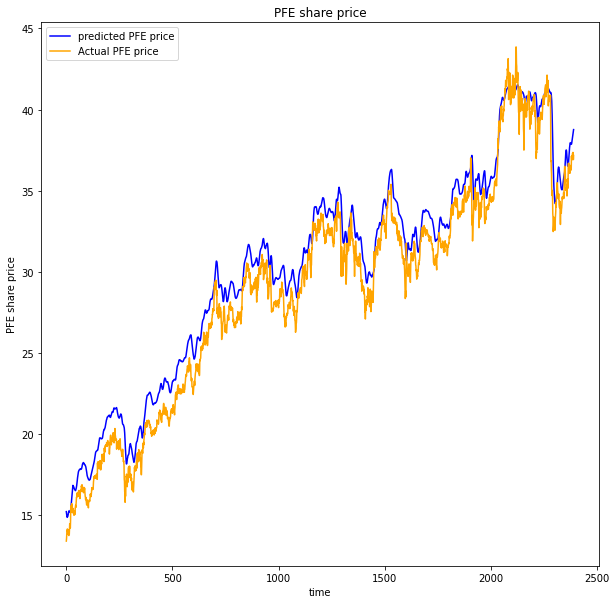

In [309]:
plt.plot(predicted, color= 'blue',label=f"predicted {company} price")
plt.plot(y_test, color= 'orange', label=f"Actual {company} price")
plt.rcParams["figure.figsize"] = (10,10)
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()

In [310]:
real_data = [x_test[len(x_test-1) - window:len(x_test+1),0]]
target_data=[y_test[len(y_test+1) - window:len(y_test+1)]]
real_data = np.array(real_data)
target_data = np.array(target_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
# target_data = np.reshape(target_data, (target_data.shape[0], target_data.shape[1], 1))
display(target_data)
real_data.shape

array([[36.90702057, 36.89753342, 36.97343445, 37.22011566, 37.30550385,
        37.27703857, 37.36243057, 37.30550385, 36.91650772, 37.17267609]])

(1, 10, 1)

In [311]:
prediction = model.predict(real_data)
actual_value = load_data(company = 'PFE',
                      start = dt.datetime(2019,12,30),
                      end = dt.datetime(2020,1,3))
print(prediction)
display(actual_value)

[[37.91988]]


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-30,37.400379,36.897533,37.286530,36.916508,11554264,35.085968
2019-12-31,37.191650,36.726753,36.802658,37.172676,15175703,35.329433
2020-01-02,37.333965,36.888046,37.286530,37.134724,16514072,35.293362
2020-01-03,37.229603,36.688805,36.736244,36.935486,14922848,35.104000
